In [70]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
import pandas as pd

# Particle filtering approaches for decoding
Here, we want to demonstrate on *artificial* data, how to decode a position with particle filtering approaches. In analogy to the real data we are facing with, we will consider a grid-like representation of the place fields. Currently, the whole demonstration has
* 1D, i.e. on a line
* no fit of the actual mouse dynamics

## Generating artificial data

### Mouse trajectories
For the mouse trajectories, we consider an integrated random walk model with reflecting boundary conditions.

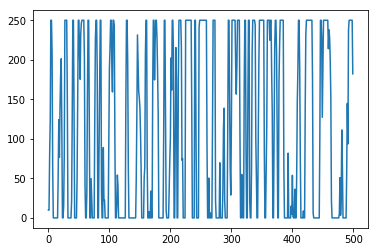

In [104]:
T = 500
dt = 1
t = np.arange(0,T,dt)
M = 5 # number of neurons
L = 250 # total length
dL = 0.1
xaxis = np.arange(0,L,dL) + dL/2 # center of bins

params = {
    "tau": 10,
    "q": 100,
    "box": np.array([0,L]),
    "dt": dt,
    "xaxis": xaxis, # axis for placefields
    "dL": dL
}

def fn(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]


X = np.zeros((int(T/dt),2)) # x and v components
X[0,0] = 10
X[0,1] = 0 
for i in np.arange(1,int(T/dt)):
    x = np.copy(X[i-1,0])
    v = np.copy(X[i-1,1])
    # integrate one timestep using Euler scheme
    X[i,0] = x + v * dt
    X[i,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(dt))
    # implement Skohorod boundary conditions
    if X[i,0] < 0:
        X[i,0] = 0 # put particle to boundary
        X[i,1] = 0 # set velocity to zero
    elif X[i,0] > L:
        X[i,0] = L # put particle to boundary
        X[i,1] = 0 # set velocity to zero
        
find_nearest = np.vectorize(lambda x: fn(xaxis, x))
X[:,0] = find_nearest(X[:,0])
        
plt.plot(t,X[:,0])
plt.show()

### Place fields
We consider a linear maze of 250 cm length and randomly generate some place fields.

In [105]:
def generatePlaceFields1D(N,xaxis,L):
    # N: number of neurons
    # L: length of the linear track
    # dL: spatial discretization
    
    
    L = xaxis[-1]
    dL = xaxis[1]-xaxis[0]
    f = np.zeros((N,xaxis.size))
    for i in range(N):
        # draw place field parameters randomly
        m = np.random.poisson(1) + 1   # number of place fields
        mu = np.random.uniform(0,L,m)  # place field centers
        sigma = np.random.uniform(dL,L/4,m) # place field width
        f0 = np.random.uniform(0,10,m) # maximal firing rate
        for j in range(m):
            f[i] = f[i] + f0[j] * np.exp(-(xaxis-mu[j])**2/sigma[j]**2)
    
    return f

In [106]:
def h(x,f,xaxis,dL):
# evaluates the place fields on a grid
# returns spiking frequencies at respective locations from x
    bins = xaxis-dL/2
    ind = np.digitize(x,bins) - 1
    hx = f[:,ind]
    
    return hx
    
    
def poisson_mean(spikes, i, x_k, x, time_bucket_length):
    if len(np.where(x==x_k)[0]) > 0:
        return spikes[np.where(x==x_k),i].sum()/(len(np.where(x==x_k)[0]) * time_bucket_length)
    return 0

def calculate_poisson(spikes, x, xaxis, time_bucket_length):
    poisson = {}
    num_neurons = spikes.shape[1]
    for x_k in xaxis:
        for i in range(num_neurons):
            pm = poisson_mean(spikes, i, x_k, x, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

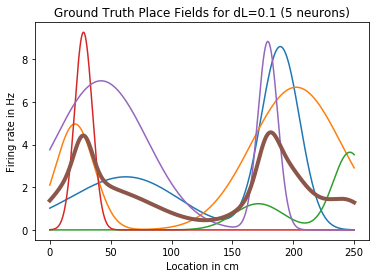

In [107]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Combine mouse trajectories with spikes

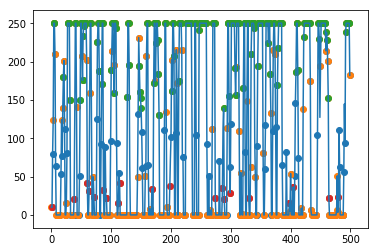

In [108]:
H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
plt.plot(t,X[:,0])
# only plot three sample cells
for i in np.arange(4):
    plt.scatter(t,np.where(dN[i,:]>0,X[:,0],np.nan))
plt.show()

## Reconstructing Place Fields 

In [109]:
spikes = dN.transpose()
X[:,0] = np.around(X[:,0],2)
xaxis = np.around(xaxis,2)
poisson_dict = calculate_poisson(spikes, X[:,0], xaxis, dt)
poisson_series = pd.Series(poisson_dict).reset_index()
poisson_series.columns = ['neuron', 'location', 'poisson_mean']
poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
params["estimated_place_fields"] = estimated_place_fields

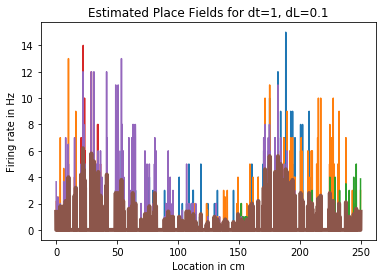

In [110]:
plt.plot(xaxis,np.transpose(estimated_place_fields))
plt.plot(xaxis,np.sum(estimated_place_fields,0)/M,linewidth=4)
plt.title("Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

In [111]:
place_field_difference = abs(f - estimated_place_fields)
total_err = place_field_difference.sum()
total_err

22959.796993020995

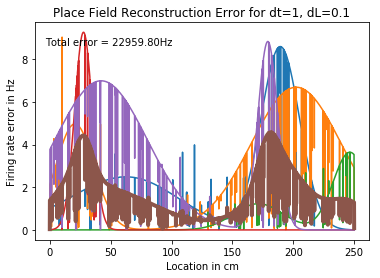

In [112]:
plt.plot(xaxis,np.transpose(place_field_difference))
plt.plot(xaxis,np.sum(place_field_difference,0)/M,linewidth=4)
plt.title("Place Field Reconstruction Error for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate error in Hz")
plt.xlabel("Location in cm")
plt.figtext(0.15,0.8,"Total error = {:.2f}Hz".format(total_err))
plt.show()

The reconstruction of place fields with small $dt<<1$ does not go well, because with $f_{i,x_k}dt<1$ where $f_i$ is the firing rate of neuron $i$ at location $x_k$, the MLE for the Poisson distribution has high variance (dependent on the actual spikes generated). This appears as strong discontinuities in our estimate for $f_i$. One solution is some form of continuity constraint on $f_i$, fitting a curve to $f_i$, or assuming something about the underlying distribution $f_i$.

## Filtering
### Bootstrap Particle filter
Now that we have some example place field data, we can implement a particle filter that is using the ground truth model.

In [113]:
def BPF(X,w,dN,params):
    # implements a simple Bootstrap Particle filter with the prior transition probability as the proposal
    P = X.shape[0]
    
    # prediction
    X_out = np.copy(X)
    x = np.copy(X[:,0])
    v = np.copy(X[:,1])
    # integrate one timestep using Euler scheme
    X_out[:,0] = x + v * dt
    X_out[:,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(params["dt"]),P)
    
    # implement Skohorod boundary conditions
    if "box" in params:
        #left border
        X_out[:,1] = np.where(X_out[:,0]<params["box"][0],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]<params["box"][0],params["box"][0],X_out[:,0])
        # right border
        X_out[:,1] = np.where(X_out[:,0]>params["box"][1],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]>params["box"][1],params["box"][1],X_out[:,0])

    
    # update (importance weights)
    # currently only dependent on position, not on velocity
    dN = np.transpose(np.tile(dN,(P,1)))
    w_out = w * np.prod( poisson.pmf(dN,h(X_out[:,0],f,xaxis,params["dL"])*dt) , 0 )
    w_out = w_out / np.sum(w_out)
    # resampling step
    if "Peff_min" in params:
        Peff = 1/np.sum(w_out**2)
        if Peff/P < params["Peff_min"]:
            X_out = X_out[np.random.choice(X_out.shape[0],P,p=w_out)]
            w_out = 1/P * np.ones(w_out.shape)
    
    return (X_out,w_out)

#### Run the particle filter

In [114]:
P = 1000
params["Peff_min"] = 0.5
X_PF = np.zeros((int(T/dt),P,2))
X_PF[0,:,0] = np.random.uniform(low=params["box"][0],high=params["box"][1],size=P)
w_PF = np.zeros((int(T/dt),P))
w_PF[0] = 1/P
# propagate particles
for i in range(1,int(T/dt)):
    X_PF[i],w_PF[i] = BPF(X_PF[i-1],w_PF[i-1],dN[:,i],params)

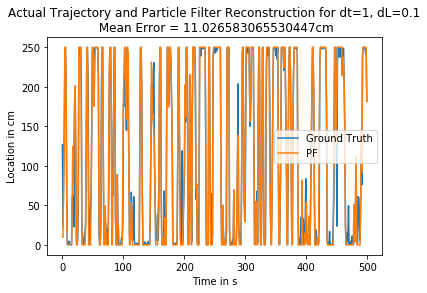

In [115]:
mu = np.sum(X_PF[:,:,0]*w_PF,1)

H = h(X[:,0],f,xaxis, dL)
dN = np.random.poisson(H * dt)
plt.plot(t,mu)
plt.plot(t,X[:,0])
# only plot three sample cells
# for i in np.array([0]):
#     plt.scatter(t,np.where(dN[i,:]>0,X[:,0],np.nan))
plt.title("Actual Trajectory and Particle Filter Reconstruction for dt={}, dL={}\n Mean Error = {}cm".format(dt, dL, abs(mu-X[:,0]).mean()))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm")
plt.xlabel("Time in s")
plt.show()

## BPF With Reconstructed Place Fields

In [116]:
def BPF_recon(X,w,dN,params):
    # implements a simple Bootstrap Particle filter with the prior transition probability as the proposal
    P = X.shape[0]
    
    # prediction
    X_out = np.copy(X)
    x = np.copy(X[:,0])
    v = np.copy(X[:,1])
    # integrate one timestep using Euler scheme
    X_out[:,0] = x + v * dt
    X_out[:,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(params["dt"]),P)
    
    # implement Skohorod boundary conditions
    if "box" in params:
        #left border
        X_out[:,1] = np.where(X_out[:,0]<params["box"][0],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]<params["box"][0],params["box"][0],X_out[:,0])
        # right border
        X_out[:,1] = np.where(X_out[:,0]>params["box"][1],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]>params["box"][1],params["box"][1],X_out[:,0])

    
    # update (importance weights)
    # currently only dependent on position, not on velocity
    dN = np.transpose(np.tile(dN,(P,1)))
    w_out = w * np.prod( poisson.pmf(dN,h(X_out[:,0],params["estimated_place_fields"],xaxis,params["dL"])*dt) , 0 )
    w_out = w_out / np.sum(w_out)
    # resampling step
    if "Peff_min" in params:
        Peff = 1/np.sum(w_out**2)
        if Peff/P < params["Peff_min"]:
            X_out = X_out[np.random.choice(X_out.shape[0],P,p=w_out)]
            w_out = 1/P * np.ones(w_out.shape)
    
    return (X_out,w_out)

### Run PF

In [117]:
X_rPF = np.zeros((int(T/dt),P,2))
X_rPF[0,:,0] = np.random.uniform(low=params["box"][0],high=params["box"][1],size=P)
w_rPF = np.zeros((int(T/dt),P))
w_rPF[0] = 1/P
# propagate particles
for i in range(1,int(T/dt)):
    X_rPF[i],w_rPF[i] = BPF_recon(X_rPF[i-1],w_rPF[i-1],dN[:,i],params)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


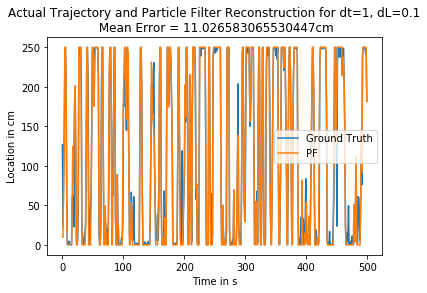

In [118]:
mu = np.sum(X_PF[:,:,0]*w_PF,1)

H = h(X[:,0],f,xaxis, dL)
dN = np.random.poisson(H * dt)
plt.plot(t,mu)
plt.plot(t,X[:,0])
# only plot three sample cells
# for i in np.array([0]):
#     plt.scatter(t,np.where(dN[i,:]>0,X[:,0],np.nan))
plt.title("Actual Trajectory and Particle Filter Reconstruction for dt={}, dL={}\n Mean Error = {}cm".format(dt, dL, abs(mu-X[:,0]).mean()))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm")
plt.xlabel("Time in s")
plt.show()

# Kush's PF

### Reconstructing Place Fields without knowing the frequencies
Here we reconstruct place fields from empirical data without knowing the underlying frequencies, and compare to the base truth

In [119]:
def resample(x,w,N):
    x_r = np.random.choice(x, p=w, size=N)
    w_r = np.ones(N) * (1.0/N)
    return x_r,w_r
    
def bootstrap_pf_zhang(y, num_particles, locations, poisson_dic, t, c, time_interval):
    x = np.zeros((t, num_particles))
    w = np.full((t, num_particles), 1/num_particles)
    poisson_series = pd.Series(poisson_dic).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_dic = pd.DataFrame(poisson_series.groupby('location').apply(lambda x: np.array(x.sort_values('neuron').poisson_mean))).to_dict('index')
    locations = np.array(locations)
    locations.sort()
    nearest = np.vectorize(lambda x: find_nearest(locations, x))
    x[0,:] = np.random.uniform(low=locations.min(), high=locations.max())
    x[0,:] = nearest(x[0,:])
    
    for i in range(1, t):
        spikes = y[i,:]
        x[i,:] = np.random.normal(x[i-1,:], 10)
        x[i,:] = nearest(x[i,:])
        # get poisson means for each neuron by particle
        poisson_means = np.array([poisson_dic[x_k][0] for x_k in x[i,:]])
        # weight updates
        w[i,:] = w[i-1,:] * np.ma.log(poisson.pmf(spikes, poisson_means)).sum(1)
        w[i,:] = w[i,:]/w[i,:].sum()
        
        Peff = 1/np.sum(w**2) 
        if Peff < c * num_particles:
            x[i,:], w[i,:] = resample(x[i,:], w[i,:], num_particles)
#             print("resample at ", i)
            
    return x, w

# params: num_particles, locations, poisson_dic, t, c, time_interval, tau, q
def bootstrap_pf_sde(y, params):
    dt = params['dt']
    poisson_dict = params['poisson_dict']
    num_particles = params['num_particles']
    locations = params['locations']
    c = params['c']
    t = params['t']
    tau = params['tau']
    q = params['q']
    
    x = np.zeros((t, num_particles, 2))
    w = np.full((t, num_particles), 1/num_particles)
    poisson_series = pd.Series(poisson_dict).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_dic = pd.DataFrame(poisson_series.groupby('location').apply(lambda x: np.array(x.sort_values('neuron').poisson_mean))).to_dict('index')
#     return poisson_dic
    locations = np.array(locations)
    locations.sort()
    nearest = np.vectorize(lambda x: fn(locations, x))
    x[0,:,0] = np.random.uniform(low=locations.min(), high=locations.max())
    x[0,:,0] = nearest(x[0,:,0])
    
    for i in range(1, t):
        spikes_i = y[i,:]
        x[i,:,0] = x[i-1,:,1] * dt + x[i-1,:,0]
        x[i,:,0] = nearest(x[i,:,0])
        x[i,:,1] = x[i-1,:,1] - 1/tau * x[i-1,:,1] * dt + q * np.random.normal(0, np.sqrt(dt), num_particles)
        
        # implement Skohorod boundary conditions
        if "box" in params:
            #left border
            x[i,:,1] = np.where(x[i,:,0]<params["box"][0],0,x[i,:,1])
            x[i,:,0] = np.where(x[i,:,0]<params["box"][0],params["box"][0],x[i,:,0])
            # right border
            x[i,:,1] = np.where(x[i,:,0]>params["box"][1],0,x[i,:,1])
            x[i,:,0] = np.where(x[i,:,0]>params["box"][1],params["box"][1],x[i,:,0])
        
        # get poisson means for each neuron by particle
        poisson_means = np.array([poisson_dic[x_k][0] for x_k in x[i,:,0]])
        # weight updates
        return spikes_i, poisson_means
        print(np.prod(poisson.pmf(spikes_i, poisson_means * dt), 1))
        w[i,:] = w[i-1,:] * np.prod(poisson.pmf(spikes_i, poisson_means * dt), 1)
        w[i,:] = w[i,:]/w[i,:].sum()
        return
        
        Peff = 1/np.sum(w**2) 
        if Peff < c * num_particles:
            x[i,:], w[i,:] = resample(x[i,:], w[i,:], num_particles)
#             print("resample at ", i)
            
    return x, w

In [120]:
# params: num_particles, locations, poisson_dic, t, c, time_interval, tau, q
# def bootstrap_pf_sde(y, params):
params = {
    "tau": 10,
    "q": 100,
    "box": np.array([0,L]),    
    "dt": dt,
    "num_particles": 1000,
    "locations": xaxis,
    "c": 0.5,
    "t": T,
    "poisson_dict":poisson_dict,
}

# x, w = bootstrap_pf_sde(spikes, params)
# mu_kush = np.sum(x[:,:,0]*w,1)

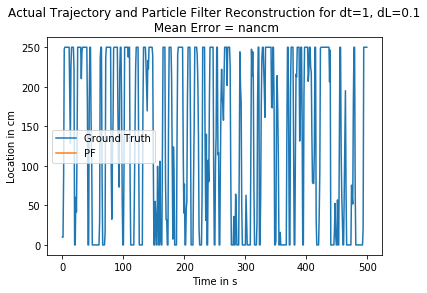

In [89]:
plt.plot(t,X[:,0])
plt.plot(t,mu_kush)
plt.title("Actual Trajectory and Particle Filter Reconstruction for dt={}, dL={}\n Mean Error = {}cm".format(dt, dL, abs(mu_kush-X[:,0]).mean()))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm")
plt.xlabel("Time in s")
plt.show()

In [92]:
x

array([[[ 2.35150000e+02,  0.00000000e+00],
        [ 2.35150000e+02,  0.00000000e+00],
        [ 2.35150000e+02,  0.00000000e+00],
        ...,
        [ 2.35150000e+02,  0.00000000e+00],
        [ 2.35150000e+02,  0.00000000e+00],
        [ 2.35150000e+02,  0.00000000e+00]],

       [[ 2.35150000e+02, -1.18717102e+01],
        [ 2.35150000e+02,  2.71348503e+01],
        [ 2.35150000e+02,  4.14672160e+01],
        ...,
        [ 2.35150000e+02, -6.78709832e+00],
        [ 2.35150000e+02, -3.83320745e+01],
        [ 2.35150000e+02, -1.28773213e+02]],

       [[ 2.23250000e+02,  7.00138677e+01],
        [ 2.49950000e+02,  5.37170614e+01],
        [ 2.49950000e+02, -6.82071432e+01],
        ...,
        [ 2.28350000e+02,  3.69927205e+01],
        [ 1.96850000e+02, -4.36308791e+01],
        [ 1.06350000e+02, -3.18423380e+02]],

       ...,

       [[ 2.49950000e+02,  8.83861897e+01],
        [ 5.00000000e-02, -4.29623348e+02],
        [ 9.78500000e+01,  2.29311217e+01],
        ...,
     

In [121]:
spikesi, pms = bootstrap_pf_sde(spikes, params)

In [122]:
spikesi

array([ 1,  5,  0,  1, 10])

In [124]:
pms

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [125]:
X[:,0]

array([9.9500e+00, 9.9500e+00, 7.9650e+01, 1.2355e+02, 2.4995e+02,
       2.4995e+02, 2.0955e+02, 6.3550e+01, 5.0000e-02, 5.0000e-02,
       5.0000e-02, 5.0000e-02, 5.0000e-02, 5.0000e-02, 5.0000e-02,
       5.0000e-02, 5.3650e+01, 1.2425e+02, 7.6550e+01, 1.3885e+02,
       1.7985e+02, 2.0125e+02, 1.1235e+02, 5.0000e-02, 5.0000e-02,
       1.5150e+01, 8.0750e+01, 2.4995e+02, 2.4995e+02, 2.4995e+02,
       2.4995e+02, 1.4935e+02, 5.0000e-02, 5.0000e-02, 5.0000e-02,
       5.0000e-02, 5.0000e-02, 5.0000e-02, 2.0550e+01, 1.2425e+02,
       2.4995e+02, 2.4995e+02, 1.4055e+02, 5.0000e-02, 5.0000e-02,
       5.0000e-02, 5.0000e-02, 5.1350e+01, 1.4945e+02, 2.4995e+02,
       2.4995e+02, 2.0735e+02, 1.7535e+02, 2.3275e+02, 2.4645e+02,
       2.4995e+02, 2.4995e+02, 2.4995e+02, 2.4995e+02, 2.0175e+02,
       4.1650e+01, 5.0000e-02, 5.0000e-02, 3.1050e+01, 1.5915e+02,
       2.4995e+02, 2.4995e+02, 1.3135e+02, 5.0000e-02, 5.0000e-02,
       4.9750e+01, 2.3350e+01, 5.0000e-02, 5.0000e-02, 5.0000e